## Setup

In [ ]:
import os
import cv2
import json
import time
import csv
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, MaxPool2D, GlobalAveragePooling2D, Lambda, Conv2D, concatenate, ZeroPadding2D, Layer, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
import tensorflow_addons as tfa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/data/research_MILDNet_tops_cropped.zip' '/content/'

In [ ]:
!unzip '/content/research_MILDNet_tops_cropped.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tops_cropped/77096.jpg  
  inflating: tops_cropped/359501.jpg  
  inflating: tops_cropped/52605.jpg  
  inflating: tops_cropped/382999.jpg  
  inflating: tops_cropped/274873.jpg  
  inflating: tops_cropped/289072.jpg  
  inflating: tops_cropped/203029.jpg  
  inflating: tops_cropped/390522.jpg  
  inflating: tops_cropped/348798.jpg  
  inflating: tops_cropped/7870.jpg   
  inflating: tops_cropped/238276.jpg  
  inflating: tops_cropped/46680.jpg  
  inflating: tops_cropped/189723.jpg  
  inflating: tops_cropped/387827.jpg  
  inflating: tops_cropped/18785.jpg  
  inflating: tops_cropped/420665.jpg  
  inflating: tops_cropped/200983.jpg  
  inflating: tops_cropped/47601.jpg  
  inflating: tops_cropped/246926.jpg  
  inflating: tops_cropped/377163.jpg  
  inflating: tops_cropped/266268.jpg  
  inflating: tops_cropped/292368.jpg  
  inflating: tops_cropped/399316.jpg  
  inflating: tops_cropped/304601.jpg  
  inflating: tops_c

##Abstract

<h2> Case Study Details </h2>
Ref Paper Link: https://arxiv.org/pdf/1901.03546v1.pdf

In this we are trying to learn the embedding of images in order to learn the visual similarity. Finding products that looks similar to a particular product is an important feature for a modern e-commerce platform. If this information is utilized correctly, can boost up user experience and purchase conversion. So, with this case study we are trying to implement a research work which uses siamense network at core to retrieve similar E-commerce images.

<h2> Dataset Used </h2>
As per the paper they have mentioned 4 different data sources using which they arrived at the final triplets for training, testing and validation purpose.
They have already shared the link from where we can actually download the csv having information for of these triplets. https://console.cloud.google.com/storage/browser/fynd-open-source/research/MILDNet




<h3> Implementation Steps </h3>

We are going to implement this work in TF2 and we'll writing custom training loops to implement this work. At the core of any NN implementation we need to identify following blocks:
1. Creating data pipeline.
2. Defining the model architecture.
3. Identifying the loss function used for computing the model loss.
4. Choosing optimizer used to update model weights.
5. Step function that encapsulates the forward & backward pass of the network.

Below mentioned implementation functions are written to encapsulate all these steps and make use of TF2 custom training functionality to implement the work.

<h3> Improvements and other updates from previous Submission </h3>

1. **Overfitting:** In last submission we were actually overfitting, reason for that was a bug in the code itself, we were actually passing the same batch of images for all the steps, so, we were actually training on same 32 images and thus overfitting.
2. **parser:** parser function has been modified as per your comments, now we don't iterate inside that, rather than dataset.map takes care of this functionality.
3. **input_pipeline:** This has also been changed, after reading file details from the tensor, we are doing a shuffle, then map function and then the batch functionality, shuffle is done at epoch level.
4. **Loss Function Implementation:** We have tfa.losses.contrastive_loss added to our code, just to let you know that if we pass a tensor of 32 to our loss, the resultant would again be a tensor of shape 32, so to find the final loss anyhow we may need to iterate and calculate the same way we did in our function, so have not made much changes to that function as a whole, instead have just added tfa.losses implementation instead of our code, although result from both these functions were same.
5. **flow function implementation:** Few changes have been made to how we get loss and accuracy value per epoch, in our last implementation, we were printing value based on the last step. but now during training we keep storing loss and accuracy for each batch and final score we give by taking average of these values. For validation once all train batches are done, we then take a batch size of 128 and iterate through all the images in val dataset and finally give the average value of loss and accuracy.

##Implementation

<h3> Data Pipeline Methods</h3>

In [ ]:
def get_image_path(path):
  '''
  This function takes the path of the csv file as input and returns a list where each element
  of the list contains a triplet with the path where the actual image is present.
  path(input): path to the csv file for train/test/cv
  img_path: path where we have kept our images
  data_path_lst(output): final list which contains triplet details for input pipeline
  '''
  data_path_lst = []
  
  global img_path 
  with open(path) as csv_file:
    data = csv.reader(csv_file, delimiter = ',')
    for row in data:
      data_path_lst.append([img_path + row[0], img_path + row[1], img_path + row[2]])

  return data_path_lst

**get_image_path:** Given a path of the csv file, this function opens the file and reads the content in that file using csv.reader, then it iterates over all the rows present in the file and for each row it adds image path before the image name and create a final list which is returned and will be used for reading during input pipeline....

In [ ]:
def input_parser(input_tensor):
  '''
  This function is used as part of data pipeline which reads image path as part of data.Dataset
  and generate the final array for the image using tf.image.decode_jpeg. 3 operations are performed
  in this function. For an image, first we read the path from the input tensor using tf.io.read_file, 
  then we use tf.image.decode_jpeg to decode the image and get a tesnor for the image and finally we
  use tf.image.resize to resize the image as per our architecture.
  input_tensor(input): tensor having image path from where images will be loaded.
  batch_size(input): Number of bacth
  img1(output): containing final tensor for query images
  img2(output): containing final tensor for positive images
  img3(output): containing final tensor for negative images
  '''
  img1 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor[0]), channels=3), [224, 224])
  img2 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor[1]), channels=3), [224, 224])
  img3 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor[2]), channels=3), [224, 224])

  return img1, img2, img3

**input_parser:** This function is used by dataset.map to get the feature tensor for each of the image. It starts by reading the file path using read_file, once this is done it extracts feature vector from an image using tf.image.decode_jpeg and finally it reshapes the final tensor per image to desired format which will be feed into the model

In [ ]:
def input_pipeline(data_path, shuffle_size, batch_size):
  '''
  This function takes in data_path and the batch_size and return final tensors
  representing each of the image.
  data_path(input): final list which contains triplet details for input pipeline
  batch_size(input): number of records for each step
  dataset(output): final dataset object containig tensor of images with a fixed batch size
  '''
  with tf.device('/cpu:0'):
    dataset = tf.data.Dataset.from_tensor_slices((np.array((data_path))))
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.map(input_parser, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).repeat()
    dataset = dataset.prefetch(1)

  return dataset

**input_pipeline:** This function uses tf.data to define the input pipeline. In the above implementation we read the input file name from an array which contains details of input file path for each image. Then we shuffle the content readed. Then we map use input_parser to get feature vector for each image and then that final tensor as dataset object is returned which will be used during modelling. Finally, we take a batch of images which are called using an iterator.

<h3> Model Architecture </h3>

![](https://drive.google.com/uc?export=view&id=112oYi4BCAugrwxLfls7-58KwaJ5wOvI3)

In [ ]:
def model_architecture():
  '''
  Ref: https://github.com/gofynd/mildnet/blob/master/trainer/model.py
  This function contains model architecture which will be used to generate final embedding for each image.
  model(output): Final model object
  '''
  pre_trained_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
  convnet = GlobalAveragePooling2D()(pre_trained_model.output)
  convnet = Dense(4096, activation = 'relu')(convnet)
  convnet = Dropout(0.5)(convnet)
  convnet = Dense(4096, activation = 'relu')(convnet)
  convnet = Dropout(0.5)(convnet)
  convnet = Lambda(lambda x : K.l2_normalize(x, axis = 1))(convnet)

  s1_inp = Input(shape = (224, 224, 3))
  s1 = MaxPool2D(pool_size = (4, 4), strides = (4, 4), padding = 'valid')(s1_inp)
  s1 = ZeroPadding2D(padding = (4, 4), data_format = None)(s1)
  s1 = Conv2D(96, kernel_size = (8, 8), strides = (4, 4), padding = 'valid')(s1)
  s1 = ZeroPadding2D(padding = (2, 2), data_format = None)(s1)
  s1 = MaxPool2D(pool_size = (7, 7), strides = (4, 4), padding = 'valid')(s1)
  s1 = Flatten()(s1)

  s2_inp = Input(shape = (224, 224, 3))
  s2 = MaxPool2D(pool_size = (8, 8), strides = (8, 8), padding = 'valid')(s2_inp)
  s2 = ZeroPadding2D(padding = (4, 4), data_format = None)(s2)
  s2 = Conv2D(96, kernel_size = (8, 8), strides = (4, 4), padding = 'valid')(s2)
  s2 = ZeroPadding2D(padding = (1, 1), data_format = None)(s2)
  s2 = MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid')(s2)
  s2 = Flatten()(s2)

  merge = concatenate([s1, s2])
  merge = Lambda(lambda x : K.l2_normalize(x, axis = 1))(merge)
  merge = concatenate([merge, convnet], axis = 1)
  embedding = Dense(4096)(merge)
  embedding = Lambda(lambda x : K.l2_normalize(x, axis = 1))(embedding)

  model = tf.keras.models.Model(inputs = [s1_inp, s2_inp, pre_trained_model.input], outputs = embedding)
  return model

**model_architecture:** Above function implements the actual model architecture, an input image is being passed to 3 different CNN architectures.
The first one is similar to VGG19, is used to encode strong invariance and capture the semantics present in an image. The other two CNN's use a shallower network architecture to capture down-sampled images. Due to the shallower architecture, these CNNs' have less invariance and are used to capture similar aspects like shapes, pattern, and color which makes the visual appearence of an image.  Thus employing three different convolution neural networks instead of a single CNN and making them share lower level layers, makes each CNN independent of the other two. At last, the embeddings from the three convolutional neural networks are normalized and combined with a 4096-dimensional linear embedding layer which encodes and represents an input image as a 4096-dimensional
vector. In order to prevent overfitting, L2 normalization is done.
Ref: https://arxiv.org/pdf/1901.03546v1.pdf

<h3> Loss Function Implementation </h3>

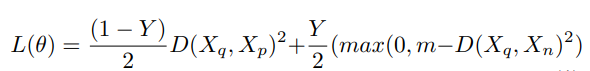

In [ ]:
def contrastive_loss_function(q_emd, p_emd, n_emd, batch_size):
  '''
  Ref: https://github.com/gofynd/mildnet/blob/master/trainer/loss.py
  This function takes embedding generated by model for each of the image
  part of the triplet and return the loss value for the batch.
  q_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  p_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  n_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  batch_size(input): batch size for each step
  loss(output): Final loss for a batch
  '''
  def _contrastive_loss(y_true, y_pred):
    return tfa.losses.contrastive_loss(y_true, y_pred)

  loss = tf.convert_to_tensor(0,dtype=tf.float32)
  g = tf.constant(1.0, shape=[1], dtype=tf.float32)
  h = tf.constant(0.0, shape=[1], dtype=tf.float32)

  for obs_num in range(batch_size):
    dist_query_pos = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - p_emd[obs_num])**2))
    dist_query_neg = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - n_emd[obs_num])**2))
    loss_query_pos = _contrastive_loss(g, dist_query_pos)
    loss_query_neg = _contrastive_loss(h, dist_query_neg)
    loss = loss + loss_query_pos + loss_query_neg

  loss = loss/(batch_size*2)
  zero = tf.constant(0.0, shape=[1], dtype=tf.float32)
  return tf.maximum(loss, zero)

**contrastive_loss_function:** This is the loss implementation of the contrastive loss function. The mathmatical objective of this loss is mentioned before the code cell. This function calcultes loss for a batch of images. For one bacth it startes by calculating loss value for each of the pair. Once we have that value, that value is added to the final loss and then loss is normalized by diving it by the 2 time the batch_size.
In the loss equation, label Y = 1 is assigned to dissimilar or negative image pairs whereas Y = 0 is alloted to similar or positive image pairs.

<h3> Accuracy function </h3>

In [ ]:
def accuracy(q_emd, p_emd, n_emd, batch_size):
  '''
  Ref: https://github.com/gofynd/mildnet/blob/master/trainer/accuracy.py
  This function takes in embedding and return the accuracy value for the batch
  q_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  p_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  n_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  batch_size(input): batch size for each step
  accuracy(output): Final accuracy value for a batch
  '''
  accuracy = 0
  for obs_num in range(batch_size):
    dist_query_pos = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - p_emd[obs_num])**2))
    dist_query_neg = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - n_emd[obs_num])**2))
    accuracy += tf.cond(dist_query_neg > dist_query_pos, lambda : 1, lambda : 0)

  return (accuracy * 100) / batch_size

**accuracy:** This function calculates the accuracy for one batch. It takes the embeding tensors for each of the image, batch_size and iterator through the batch to give a value of 1 if neg_dist > pos_dist or 0 otherwise. It finally returns the final accuracy for a batch.

<h3> Train Step Implementation </h3>

In [ ]:
@tf.function
def train_step(data, batch_size):
  '''
  This is the custom function which will be responsible for trainig based
  on the training dataset, here we first calculate the embedding for our triplet.
  Then, we'll find the loss and accuracy value using the embedded tensors.
  Finally, we use loss value and gradient tape to calculate the gradients and 
  optimizer to update weights. All of these operations are done for one step and
  we keep on updating weights untill convergence.
  data(input): input tensor
  loss_value(output): loss value for the batch before updating weights
  accuracy_value(output): accuracy value for the batch before updating weights
  '''
  with tf.GradientTape() as tape:
    q_emd = model((data[0], data[0], data[0]), training = True)
    p_emd = model((data[1], data[1], data[1]), training = True)
    n_emd = model((data[2], data[2], data[2]), training = True)

    loss_value = contrastive_loss_function(q_emd, p_emd, n_emd, batch_size)
    accuracy_value = accuracy(q_emd, p_emd, n_emd, batch_size)

  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  return loss_value, accuracy_value

**train_step:** This is where we use gradient tape to perform actual training. In our case since we are dealing with triplets, for one batch we first find the embedding for each of the image in that batch such that we get embedding for query, positive and negative image. This embedding is generated using model architecture that was defined. Once we have this, we will then calculate loss and accuracy for that batch and then based on the loss retured finally we calculate gradients using the gradient tape. Once we have these gradients with us we use optimizer object to update weights.

**tf.function decorator is used to cause tensorflow autograph working and accelerate execution for those operation inside it. When we call a @tf.function decorator the first time, tensorflow will first convert it into a graph, then execute it, after that, when we call the function again, it'll just execute the graph.**

<h3> Validation step implementation </h3>

In [ ]:
@tf.function
def val_step(data, batch_size):
  '''
  This function is the step function which finds the loss value and the accuracy
  on a bacth of data for each step in an epoch on validation data. No training is
  done within this bock, instead we just find the embedding and based on what model
  has learned in the train phase we get the final loss and accuracy on validation data
  data(input): input tensor
  loss_value(output): loss value for the batch before updating weights
  accuracy_value(output): accuracy value for the batch before updating weights
  '''
  q_emd = model((data[0], data[0], data[0]), training = False)
  p_emd = model((data[1], data[1], data[1]), training = False)
  n_emd = model((data[2], data[2], data[2]), training = False)

  loss_value = contrastive_loss_function(q_emd, p_emd, n_emd, batch_size)
  accuracy_value = accuracy(q_emd, p_emd, n_emd, batch_size)

  return loss_value, accuracy_value

**val_step:** This function is responsible for giving us validation loss and accuracy on validation dataset per step for an epoch. This function uses the model(trained with updated weights) to generate embedding and based on those genearted embedding we calculate the loss and accuracy.

<h3> Final Flow Implemetation </h3>

In [ ]:
def flow(epochs, batch_size):
  #define path from where data will be read
  train_csv_file = '/content/drive/My Drive/data/tops_train.csv'
  cv_csv_file = '/content/drive/My Drive/data/tops_val.csv'
  val_batch_size = 128

  #calling get_image_path to get a list of triplets with actual path
  train_data_path = get_image_path(train_csv_file)
  validation_data_path = get_image_path(cv_csv_file)
  train_loss = tf.metrics.Mean(name="train_loss")
  train_accuracy = tf.metrics.Mean(name="train_acc")

  #Starting the actual flow from where we will start training using our custom function, enabling GPU for training
  with tf.device('/gpu:0'):
    for epoch in range(epochs):
      epoch_start_time = time.time()
      print('*'*100)
      print('Epoch: {}'.format(epoch + 1))
      train_dataset = input_pipeline(train_data_path, len(train_data_path), batch_size) # calling pipeline method to generate train dataset
      train_iterator = iter(train_dataset) # Creating an iterator on the dataset

      train_loss.reset_states()
      train_accuracy.reset_states()
      loss_, acc_ = [], []
      for step in range(len(train_data_path) // batch_size):
      #for step in range(2):
        
        train_data = train_iterator.get_next() #Calling a batch of dataset
        train_loss_value, train_accuracy_value = train_step(train_data, batch_size) # Calling train step function on the fetched batch
        loss_.append(train_loss_value.numpy()[0])
        acc_.append(train_accuracy_value)
        #print(train_loss)

        #Printing loss and accuracy value after every 200 steps in an epoch
        if step % 200 == 0:
          print('\t{} train samples seen so far'.format((step + 1) * batch_size)) 
          print('\tTraining loss(for one batch) at step {} is {}'.format(step + 1, train_loss_value))
          print('\tTraining accuracy(for one batch) at step {} is {}'.format(step + 1, train_accuracy_value))
      
      train_loss.update_state(loss_)
      train_accuracy.update_state(acc_)

      val_accuracy, val_loss = [], []
      validation_dataset = input_pipeline(validation_data_path, len(validation_data_path), val_batch_size)
      validation_iterator = iter(validation_dataset)
      for _ in range(len(validation_data_path) // val_batch_size):
        validation_data = validation_iterator.get_next()
        validation_loss_value, validation_accuracy_value = val_step(validation_data, val_batch_size)
        val_loss.append(validation_loss_value.numpy()[0])
        val_accuracy.append(validation_accuracy_value)
      
      #printing loss and accuracy value after the end of epoch on final batch of that epoch
      print('Train loss after epoch {} is: {}'.format(epoch + 1, train_loss.result().numpy()))
      print('Validation loss after epoch {} is: {}'.format(epoch + 1, round(np.mean(np.array(val_loss)), 6)))
      print('Train Accuracy after epoch {} is: {}'.format(epoch + 1, train_accuracy.result().numpy()))
      print('Validation Accuracy after epoch {} is: {}'.format(epoch + 1, round(np.mean(np.array(val_accuracy)), 2)))
      print('Time taken to complete epoch {} is: {} mins'.format(epoch + 1, round((time.time() - epoch_start_time) / 60, 2)))
      
      # write them to the tensorboard
      with tf.name_scope("per_epoch_params"):
        with wtrain.as_default():
          tf.summary.scalar("loss", train_loss.result().numpy(), step=epoch)
          tf.summary.scalar("acc", train_accuracy.result().numpy(), step=epoch)
          wtrain.flush()

        with wval.as_default():
          tf.summary.scalar("loss", round(np.mean(np.array(val_loss)), 6), step=epoch)
          tf.summary.scalar("acc", round(np.mean(np.array(val_accuracy)), 2), step=epoch)
          wval.flush()
      model.save_weights('epoch{}model.h5'.format(epoch + 1))
      print('Model weights saved!!!!')

**flow:** This function call all the other function to perform custom training for our whole architecture. In the above function, we first define the path of the images and the files which will be used to fetch data.
Then we start our training loop where we enable the usage of available GPU for faster training. Once this is done, we start by first reading data for a bacth. For doing that we create an iterator object which will give us data in batches. Once this is done, we'll then call the step function to train, we keep on recording the scores we get during each step of training inside an epoch and finally when this is done, we use validation set to calculate the loss and accuracy and print the final one for both train and validation. Model weights are also saved after each epoch

<h3> Executing the main function to train </h3>

In [ ]:
if __name__ == '__main__':
  img_path = '/content/tops_cropped/'
  wtrain = tf.summary.create_file_writer(logdir = 'logs/train')
  wval = tf.summary.create_file_writer(logdir = 'logs/val')
  model = model_architecture()
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) #defining optimizer
  flow(10, 32) # 10 epochs, batch size of 32

80142336/80134624 [==============================] - 0s 0us/step
****************************************************************************************************
Epoch: 1
	32 train samples seen so far
	Training loss(for one batch) at step 1 is [0.4130037]
	Training accuracy(for one batch) at step 1 is 62.5
	6432 train samples seen so far
	Training loss(for one batch) at step 201 is [0.18301491]
	Training accuracy(for one batch) at step 201 is 87.5
	12832 train samples seen so far
	Training loss(for one batch) at step 401 is [0.15259127]
	Training accuracy(for one batch) at step 401 is 87.5
	19232 train samples seen so far
	Training loss(for one batch) at step 601 is [0.10246877]
	Training accuracy(for one batch) at step 601 is 96.875
	25632 train samples seen so far
	Training loss(for one batch) at step 801 is [0.13063873]
	Training accuracy(for one batch) at step 801 is 90.625
	32032 train samples seen so far
	Training loss(for one batch) at step 1001 is [0.15094765]
	Training acc

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Epoch #', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy']

x.add_row([1, .1350, .1228, 90.13, 91.97])
x.add_row([2, .0845, .1176, 96.09, 93.4])
x.add_row([3, .0667, .1158, 97.37, 93.93])
x.add_row([4, .0576, .1114, 98.18, 94.19])
x.add_row([5, .0515, .1802, 98.64, 92.98])
x.add_row([6, .0462, .1371, 98.95, 94.08])
x.add_row([7, .0423, .2026, 99.20, 92.25])
x.add_row([8, .0385, .1797, 99.36, 92.38])
x.add_row([9, .0353, .2226, 99.53, 91.78])
x.add_row([10, .0327, .2382, 99.62, 91.22])

print(x)

+---------+------------+----------+----------------+--------------+
| Epoch # | Train Loss | Val Loss | Train Accuracy | Val Accuracy |
+---------+------------+----------+----------------+--------------+
|    1    |   0.135    |  0.1228  |     90.13      |    91.97     |
|    2    |   0.0845   |  0.1176  |     96.09      |     93.4     |
|    3    |   0.0667   |  0.1158  |     97.37      |    93.93     |
|    4    |   0.0576   |  0.1114  |     98.18      |    94.19     |
|    5    |   0.0515   |  0.1802  |     98.64      |    92.98     |
|    6    |   0.0462   |  0.1371  |     98.95      |    94.08     |
|    7    |   0.0423   |  0.2026  |      99.2      |    92.25     |
|    8    |   0.0385   |  0.1797  |     99.36      |    92.38     |
|    9    |   0.0353   |  0.2226  |     99.53      |    91.78     |
|    10   |   0.0327   |  0.2382  |     99.62      |    91.22     |
+---------+------------+----------+----------------+--------------+


We can see the best results we got was for 4th Epoch, hence that will be used as final model on validation set.

In [ ]:
!ls -l epoch*

-rw-r--r-- 1 root root 273326312 Dec 30 15:39 epoch10model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 06:57 epoch1model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 07:55 epoch2model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 08:53 epoch3model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 09:51 epoch4model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 10:49 epoch5model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 11:47 epoch6model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 12:45 epoch7model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 13:43 epoch8model.h5
-rw-r--r-- 1 root root 273326312 Dec 30 14:41 epoch9model.h5


In [ ]:
!cp epoch* '/content/drive/My Drive/weight/'

#Validation Block

In [ ]:
def val_flow(cv_csv_file):
  '''
  This function is used to perform validation in 2 steps, first step is by taking
  a batch of images and computing loss and accuracy for that bacth, In this 
  validation exercise we have taken 5 batches which have randomly shuffled images.
  2nd validation step is taking just one triplet and finding the embedding and 
  identifying if model is working correctly or not.
  '''
  validation_data_path = get_image_path(cv_csv_file)

  with tf.device('gpu:0'):
    #Performing 5 step validation steps
    for cv_step in range(5):
      val_batch_size = 128 #Taking a batch size beyond 128 is OOM error

      #Generating data for model to predict
      validation_dataset = input_pipeline(validation_data_path, len(validation_data_path), val_batch_size)
      validation_iterator = iter(validation_dataset)
      validation_data = validation_iterator.get_next()
     # print(validation_data)
     #Calling val_step function to get loss and accuracy value on validation set of 128 images
      validation_loss_value, validation_accuracy_value = val_step(validation_data, val_batch_size)
      print('Validation loss and accuracy for {} validation step on {} random data points from validation set are: {}, {}'.format(cv_step + 1, val_batch_size, validation_loss_value, validation_accuracy_value))

    #Checking model prediction on 5 random data points
    for cv_step in range(5):

      #Fetching just one image from our pipeline
      val_batch_size = 1
      validation_dataset = input_pipeline(validation_data_path, len(validation_data_path), val_batch_size)
      validation_iterator = iter(validation_dataset)
      validation_data = validation_iterator.get_next()

      #Getting embedding for the image from the model
      q_emd = model((validation_data[0], validation_data[0], validation_data[0]), training = False)
      p_emd = model((validation_data[1], validation_data[1], validation_data[1]), training = False)
      n_emd = model((validation_data[2], validation_data[2], validation_data[2]), training = False)

      #Finding Distance between the images
      dist_query_pos = tf.sqrt(tf.reduce_sum((q_emd - p_emd)**2))
      dist_query_neg = tf.sqrt(tf.reduce_sum((q_emd - n_emd)**2))

      #Generating result
      print('For {} sample, distance b/w q & p is {} and distance b/w q & n is {}.... Model performed {}'.format(cv_step + 1, round(dist_query_pos.numpy(), 3), round(dist_query_neg.numpy(), 3), 'correctly' if dist_query_pos < dist_query_neg else 'incorrectly'))


In [ ]:
model = model_architecture() # calling model architecture function
model.load_weights('/content/drive/My Drive/weight/epoch4model.h5') # Loading weights for model saved after 4th epoch

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
img_path = '/content/tops_cropped/'
cv_csv_file = '/content/drive/My Drive/data/tops_val.csv'
val_flow(cv_csv_file)

Validation loss and accuracy for 1 validation step on 128 random data points from validation set are: [0.09825949], 93.75
Validation loss and accuracy for 2 validation step on 128 random data points from validation set are: [0.11328403], 92.96875
Validation loss and accuracy for 3 validation step on 128 random data points from validation set are: [0.09866808], 97.65625
Validation loss and accuracy for 4 validation step on 128 random data points from validation set are: [0.10503161], 96.875
Validation loss and accuracy for 5 validation step on 128 random data points from validation set are: [0.12064635], 94.53125
For 1 sample, distance b/w q & p is 0.11800000071525574 and distance b/w q & n is 1.7979999780654907.... Model performed correctly
For 2 sample, distance b/w q & p is 0.15700000524520874 and distance b/w q & n is 0.843999981880188.... Model performed correctly
For 3 sample, distance b/w q & p is 0.33500000834465027 and distance b/w q & n is 1.621999979019165.... Model performed

From above we can see that when taken batch of images on an avg we are getting an accuracy of 95%, also, when taken just 1 image for this run model performed correctly all the time for multiple runs....
